In [2]:
### imports ###
import pygmt
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.image as mpimg 
from mpl_toolkits.basemap import Basemap


import ipywidgets as widgets


%matplotlib widget

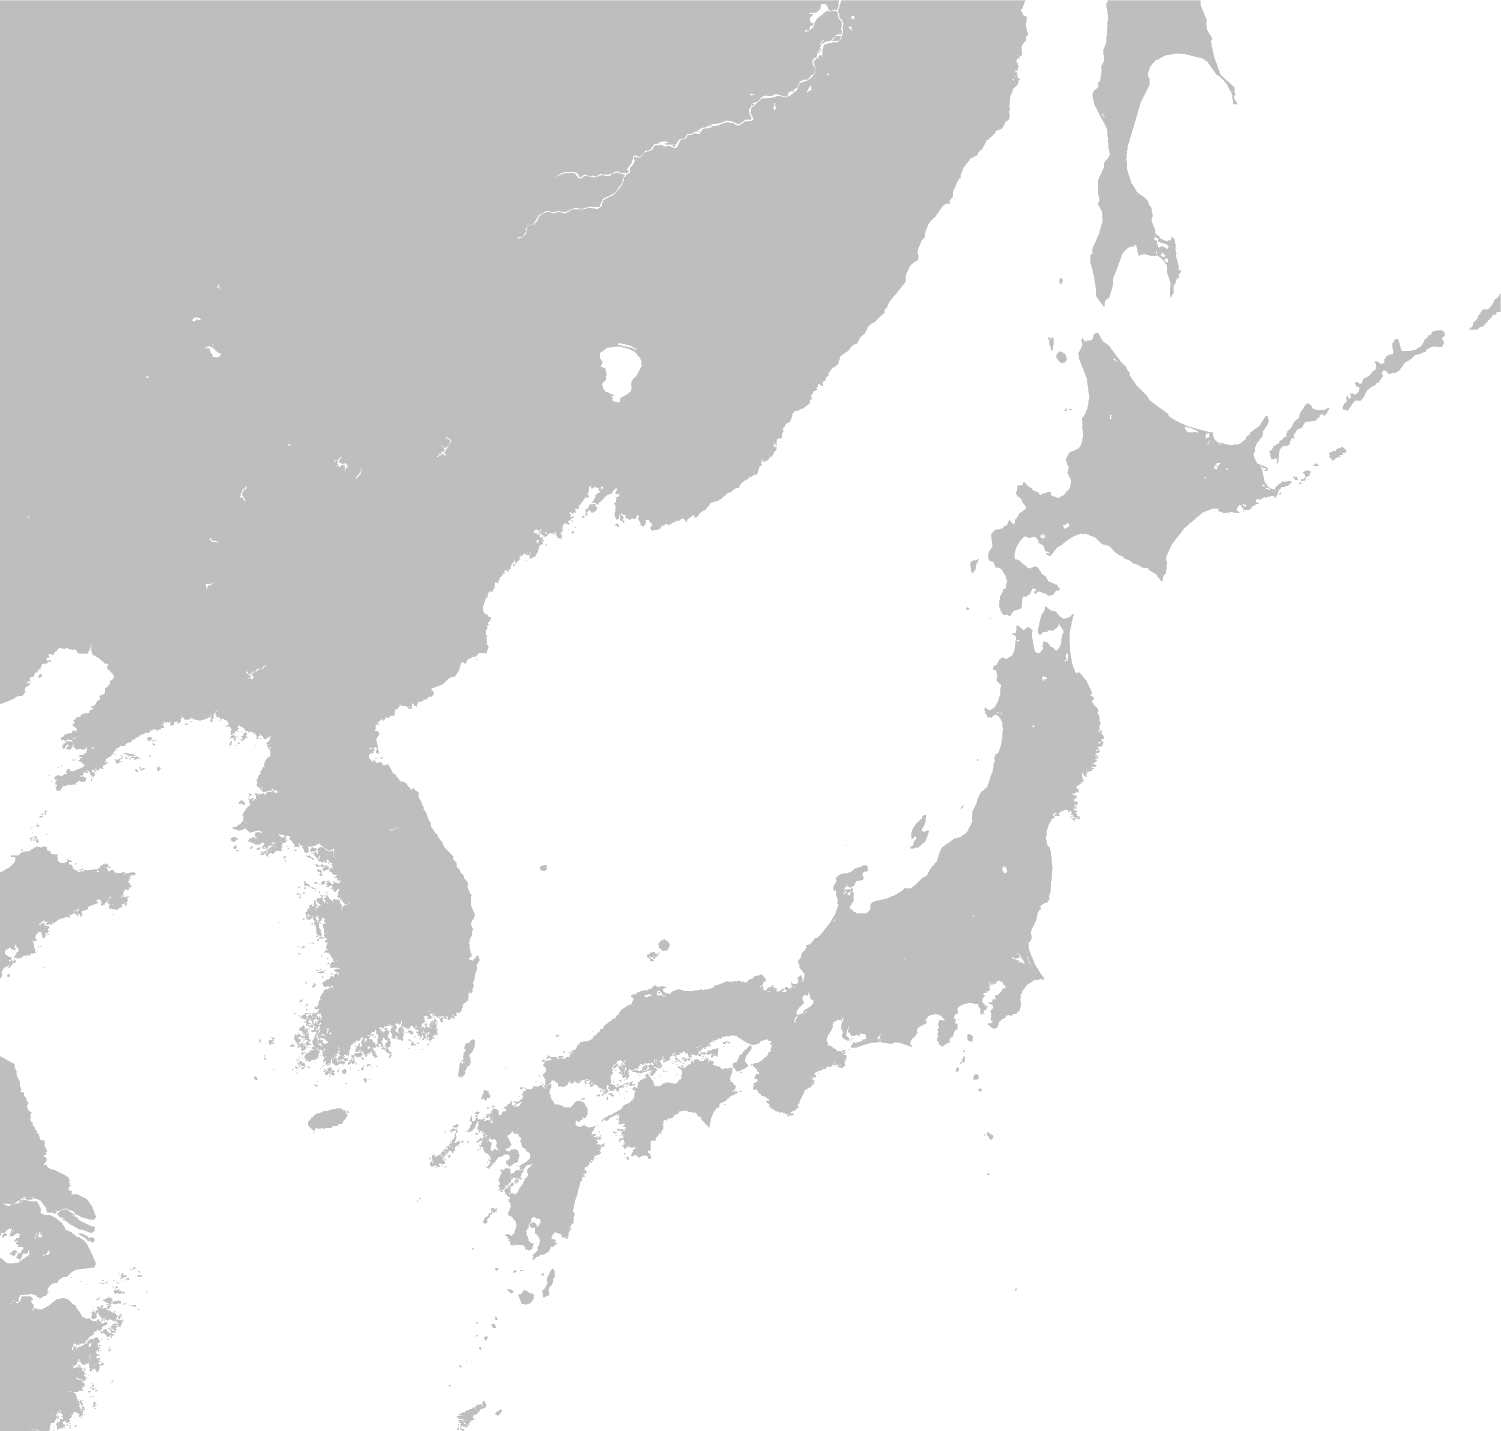

In [13]:
### GMT basemap ###

###########################################
## Specify coords
# llcrnrlat,llcrnrlon, urcrnrlat, urcrnrlon
# are the lat/lon values of the lower left and upper right corners of the map

llcrnrlon=120 # lower left corner longitude 
llcrnrlat=28 # lower left corner latitude
urcrnrlon=150 # upper right corner longitude
urcrnrlat=50 # upper right corner latitude

proj_scale_w = 5 # specify projection scale (width)
proj_scale_unit = "i" # choose between c (cm) and i (inches)

grid_freq = 5 # grid frequency (degrees)

###########################################

centerlon = (urcrnrlon - llcrnrlon)/2 + llcrnrlon # midpoints
centerlat = (urcrnrlat - llcrnrlat)/2 + llcrnrlat


fig = pygmt.Figure()
fig.coast(region=[llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat],\
          projection="M%s/%s/%s%s" % (centerlon, urcrnrlat, proj_scale_w, proj_scale_unit),\
          land="grey", shorelines=False)

          # Mercator
          # M[lon0/lat0] optionally sets central meridian and standard parallel
          # but idk how GMT determines the defaults so i left it in
fig.show()
fig.savefig("pygmt_base_map.png", transparent=True)

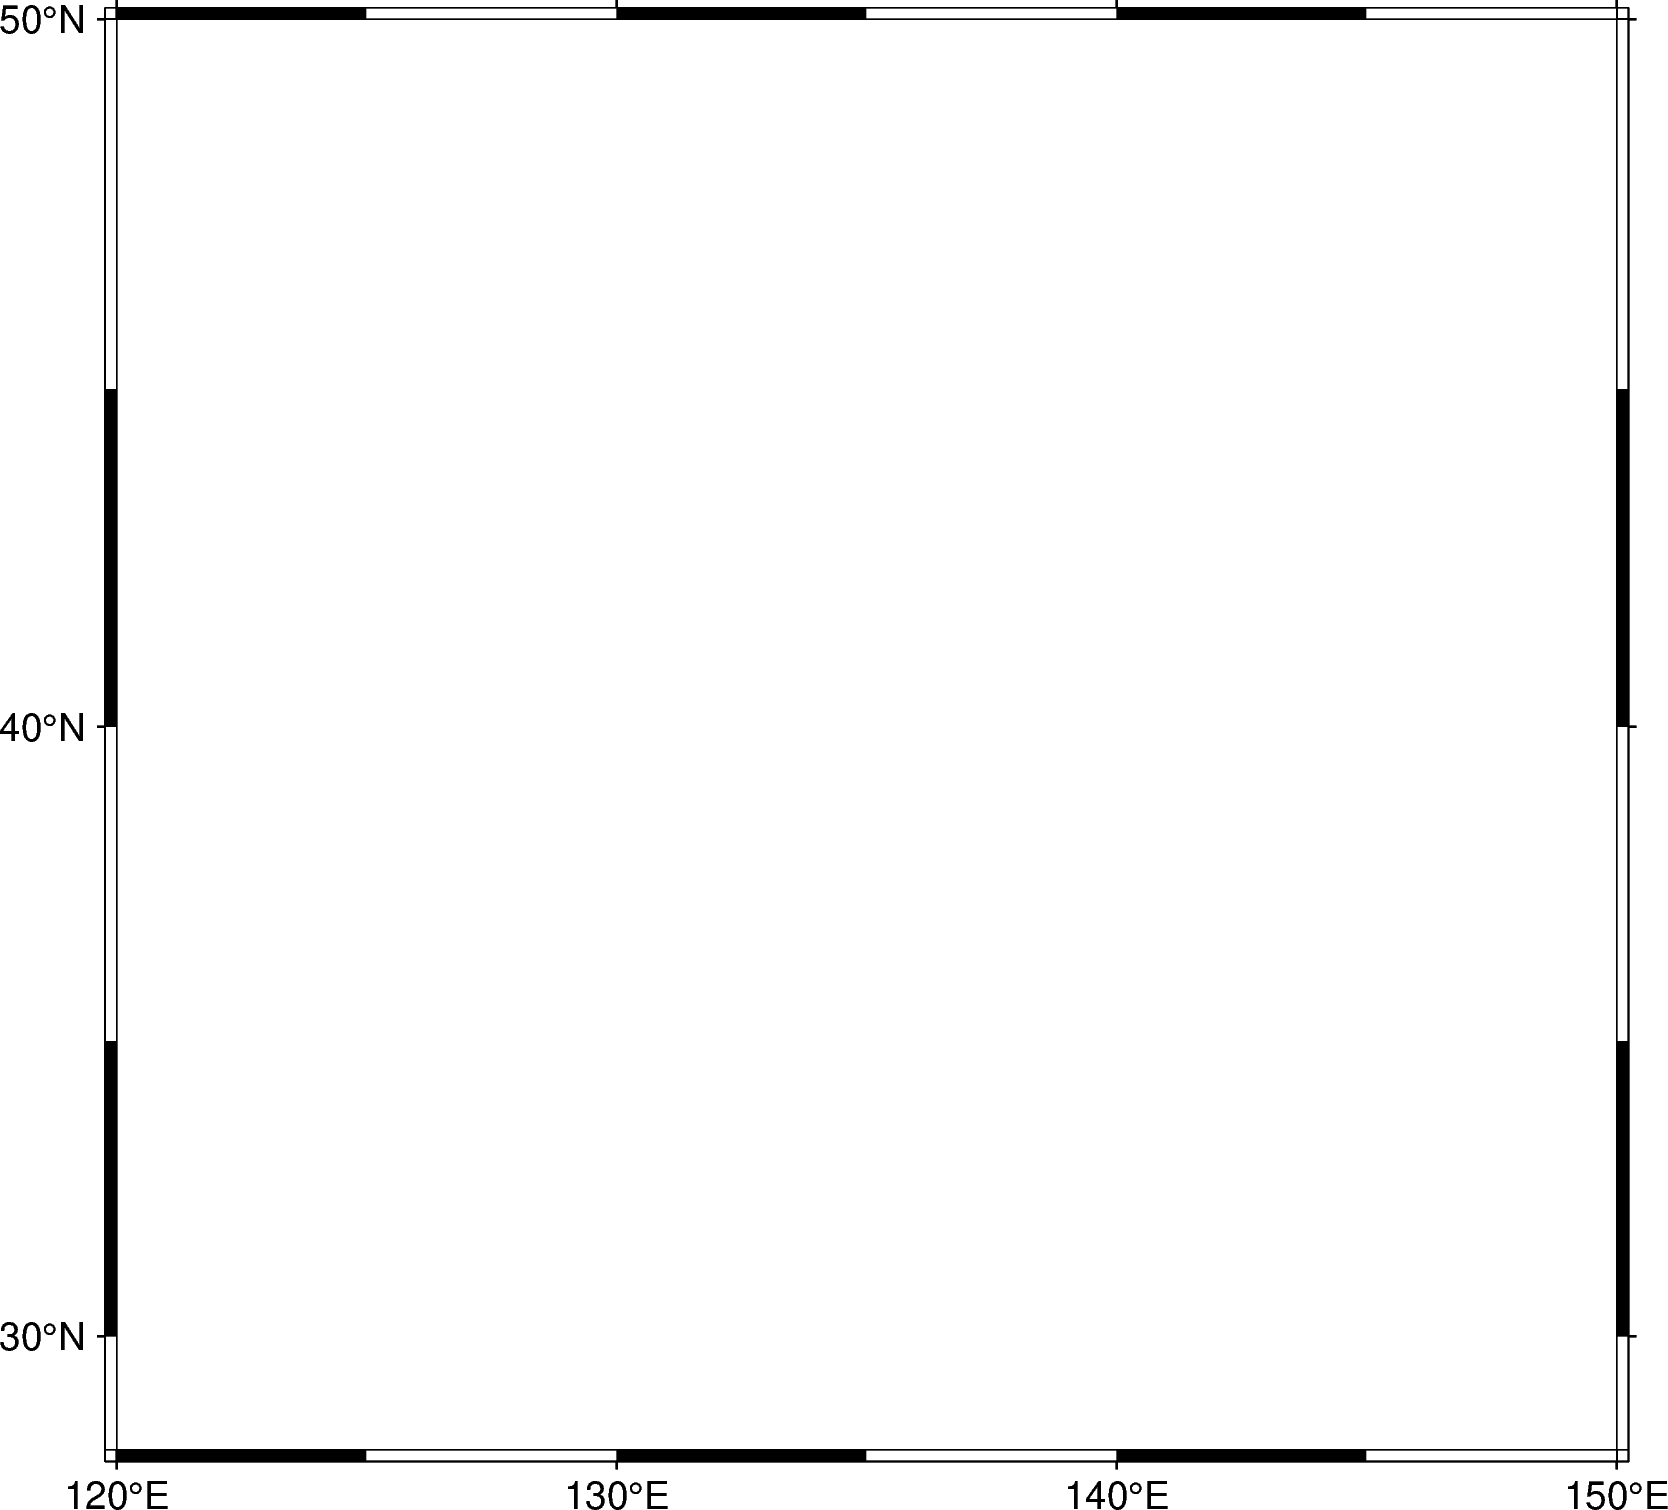

In [14]:
fig = pygmt.Figure()

fig.basemap(region=[llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat],\
          projection="M%s/%s/%s%s" % (centerlon, urcrnrlat, proj_scale_w, proj_scale_unit),\
          frame="a10f5")

fig.show()
fig.savefig("pygmt_border.png", transparent=True)

'\nplot_widget = widgets.Output()\nwith plot_widget:\n    display(fig.canvas)\n\nwith open("pygmt_border.png", "rb") as file:\n    overlay_img = file.read()\n\n\nborder = widgets.Image(value=overlay_img, format=\'png\')\n\nlogo_layout = widgets.Layout(\n    display=\'flex\',\n    justify_content=\'center\',\n    align_items=\'center\',\n)\n\nhbox = widgets.HBox([plot_widget, border])\ndisplay(hbox)\n'

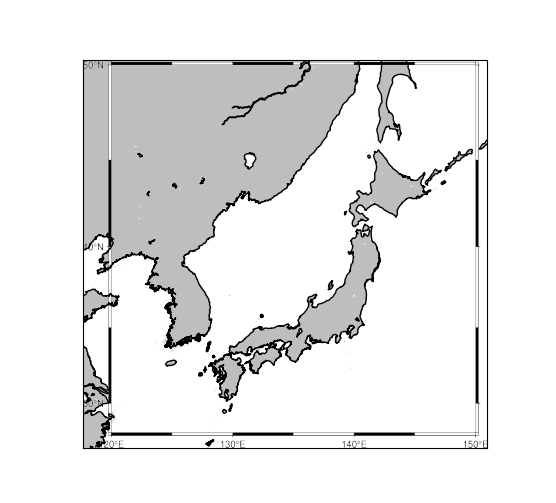

In [46]:
### interactive pygmt not a function ###
'''
Creates an interactive map from a borderless pyGMT png where you can click to retrieve coordinates.

Parameters:
    png_path (str): path to the borderless pyGMT map
    llcrnrlon (float): lower left corner longitude
    llcrnrlat (float): lower left corner latitude
    urcrnrlon (float): upper right corner longitude
    urcrnrlat (float): upper right corner latitude

'''
png_path = "pygmt_base_map.png"
border_path = "pygmt_border.png"

# determine image dimension
img = Image.open(border_path)
width, height = img.size # (width,height) tuple in pixels
DPI_horz, DPI_vert = img.info.get('dpi')

assert DPI_horz == DPI_vert

fig = plt.figure(figsize=(width/DPI_horz, height/DPI_horz))
ax1 = fig.add_subplot(111)

# gs = fig.add_gridspec(3, 3)
# ax1 = fig.add_subplot(gs[1, 1])


# creating matplotlib basemap for overlay
m = Basemap(projection='merc', resolution='i',\
                        llcrnrlat=llcrnrlat, urcrnrlat=urcrnrlat,\
                        llcrnrlon=llcrnrlon, urcrnrlon=urcrnrlon)

m.drawcoastlines() # draws coastlines on matplotlib. this makes sure that everything is aligned

'''
  # plotting parallels and meridians, annotating axis
  parallels = np.arange(-90, 90, grid_freq)
  meridians = np.arange(-180, 180, grid_freq)
  m.drawparallels(parallels, labels=[1,0,0,0], fontsize=12, linewidth=0.5) # label parallels on right and top
  m.drawmeridians(meridians, labels=[0,0,0,1], fontsize=12, linewidth=0.5) # meridians on bottom and left
'''

# plotting pygmt png image in bottom layer
img = mpimg.imread(border_path)
m.imshow(img, origin='upper', zorder=1)

img = mpimg.imread(png_path)
m.imshow(img, origin='upper')


def pos_to_lonlat(x, y):
  lon, lat = m(x, y, inverse=True)
  return lon, lat

pos = [] # in format [[None, None], [x, y], [x, y], ...]
lonlat = []

def onclick(event):
  pos.append([event.xdata, event.ydata])

  lon, lat = pos_to_lonlat(pos[-1][0], pos[-1][1]) # pos[-1] represents last click (list with x, y)
  lonlat.append([lon, lat]) # converts x y to lon lat and appends

  ax1.set_title(f'Click {len(pos)}: {lon}, {lat}') 


fig.canvas.toolbar_visible = False # hides toolbar
fig.canvas.resizable = False # disable resizing
fig.canvas.capture_scroll = True # If true then scrolling while the mouse is over the canvas will not move the entire notebook
cid=fig.canvas.mpl_connect('button_press_event', onclick)

###################
border_img = mpimg.imread(border_path)
ax1.imshow(border_img, extent=[0, width, 0, height], zorder=2, alpha=0.5)

'''
import matplotlib.transforms as mtransforms
extent = [-1, 1, -1, 1]
trans = mtransforms.Affine2D().scale(fig.dpi/72.0) + ax1.transAxes
border_img = mpimg.imread(border_path)
ax1.imshow(border_img, origin="upper", extent=extent, clip_on=False)
'''

'''
plot_widget = widgets.Output()
with plot_widget:
    display(fig.canvas)

with open("pygmt_border.png", "rb") as file:
    overlay_img = file.read()


border = widgets.Image(value=overlay_img, format='png')

logo_layout = widgets.Layout(
    display='flex',
    justify_content='center',
    align_items='center',
)

hbox = widgets.HBox([plot_widget, border])
display(hbox)
'''


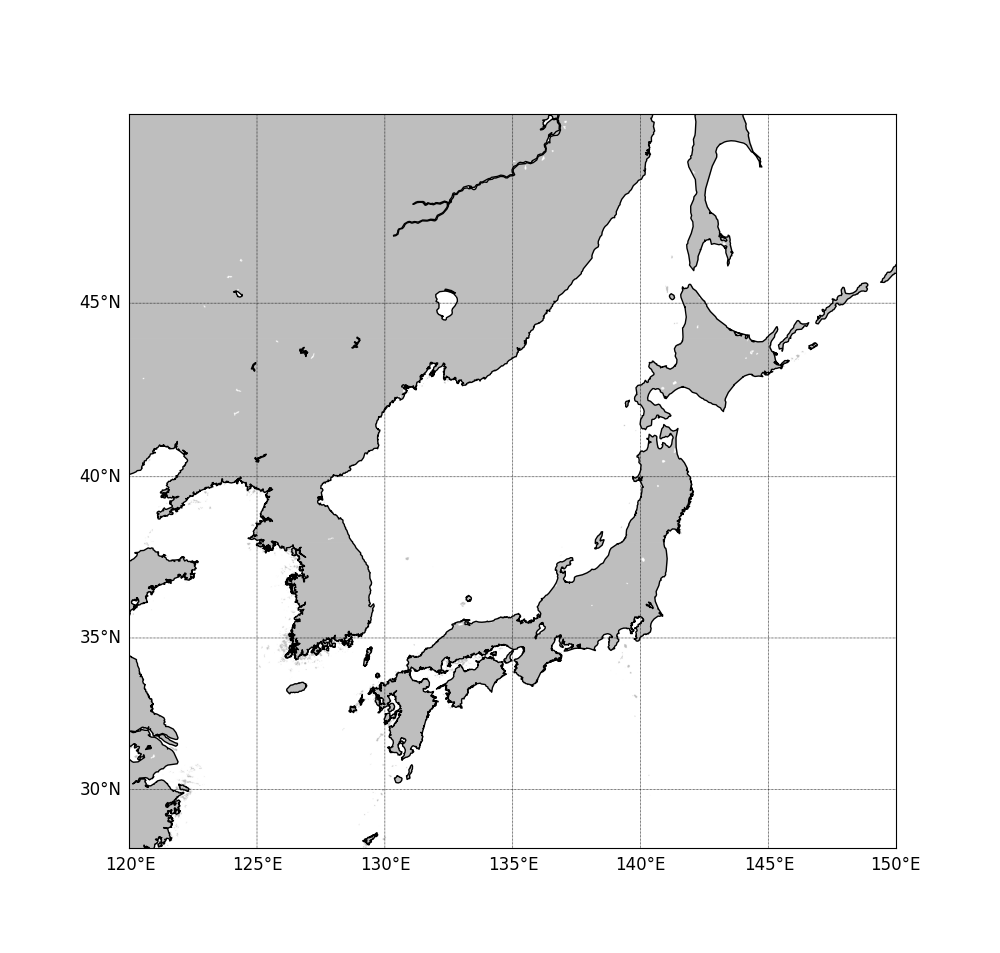

In [18]:
interactive_pygmt("pygmt_base_map.png", llcrnrlat, urcrnrlat, llcrnrlon, urcrnrlon)